In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
import re

import warnings
warnings.filterwarnings("ignore")

In [ ]:
train_df = pd.read_json('./drive/MyDrive/train.jsonl', lines=True)
val_df = pd.read_json('./drive/MyDrive/val.jsonl', lines=True)

In [ ]:
print(f'{train_df.shape[0]} is train_df size')
print(f'{val_df.shape[0]} is val_df size')

9427 is train_df size
3270 is val_df size


In [ ]:
base_train = train_df[train_df['label']].shape[0]/train_df.shape[0]
print(f'positive answers proportion in training data:{base_train: .3}')

base_val = val_df[val_df['label']].shape[0]/val_df.shape[0]
print(f'positive answers proportion in validation data:{base_val: .3}')

positive answers proportion in training data: 0.623
positive answers proportion in validation data: 0.622


In [ ]:
# let's combine the training and validation part of the data so that they get the same changes
train_df['purpose'] = 'train'
val_df['purpose'] = 'val'
df = train_df.append(val_df, ignore_index=True)

In [ ]:
df.head()

,question,passage,idx,label,purpose
0,do iran and afghanistan speak the same language,"Persian language -- Persian (/ˈpɜːrʒən, -ʃən/)...",0,True,train
1,do good samaritan laws protect those who help ...,Good Samaritan law -- Good Samaritan laws offe...,1,True,train
2,is windows movie maker part of windows essentials,Windows Movie Maker -- Windows Movie Maker (fo...,2,True,train
3,is confectionary sugar the same as powdered sugar,"Powdered sugar -- Powdered sugar, also called ...",3,True,train
4,is elder scrolls online the same as skyrim,The Elder Scrolls Online -- As with other game...,4,False,train


In [ ]:
print('negative answer example')
print('question:', df[df['label']==False]['question'].values[0])
print('passage:', df[df['label']==False]['passage'].values[0])
print()

negative answer example
question: is elder scrolls online the same as skyrim
passage: The Elder Scrolls Online -- As with other games in The Elder Scrolls series, the game is set on the continent of Tamriel. The events of the game occur a millennium before those of The Elder Scrolls V: Skyrim and around 800 years before The Elder Scrolls III: Morrowind and The Elder Scrolls IV: Oblivion. It has a broadly similar structure to Skyrim, with two separate conflicts progressing at the same time, one with the fate of the world in the balance, and one where the prize is supreme power on Tamriel. In The Elder Scrolls Online, the first struggle is against the Daedric Prince Molag Bal, who is attempting to meld the plane of Mundus with his realm of Coldharbour, and the second is to capture the vacant imperial throne, contested by three alliances of the mortal races. The player character has been sacrificed to Molag Bal, and Molag Bal has stolen their soul, the recovery of which is the primary gam

In [ ]:
print('positive answer example')
print('question:', df[df['label']==True]['question'].values[0])
print('passage:', df[df['label']==True]['passage'].values[0])

positive answer example
question: do iran and afghanistan speak the same language
passage: Persian language -- Persian (/ˈpɜːrʒən, -ʃən/), also known by its endonym Farsi (فارسی fārsi (fɒːɾˈsiː) ( listen)), is one of the Western Iranian languages within the Indo-Iranian branch of the Indo-European language family. It is primarily spoken in Iran, Afghanistan (officially known as Dari since 1958), and Tajikistan (officially known as Tajiki since the Soviet era), and some other regions which historically were Persianate societies and considered part of Greater Iran. It is written in the Persian alphabet, a modified variant of the Arabic script, which itself evolved from the Aramaic alphabet.


Next, we will work on text preprocessing. Especially we will have to clean up texts that have been get from Wikipedia.

In [ ]:
# installing instrument swapping "I'd" by "I would", "they've" by "they have" and so on
!pip install contractions
import contractions

# defining a function that formats each text
def format_text(text):
    text = text.lower() # make lowercase
    text = contractions.fix(text) # replace apostrophic short constructions
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # remove urls
    text = re.sub(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', '', text) # remove html tags
    text = re.sub(r'[^\x00-\x7f]', '', text) # remove non ascii
    text = re.sub(r'[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]+', '', text) # remove normal symbols
    return text
    # in the dataset, the texts are taken from Wikipedia, so here we may 
    # not use emoji cleaning and does not work on cases with informal speech

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 5.1 MB/s 
     |████████████████████████████████| 106 kB 28.0 MB/s 


In [ ]:
df['passage_formated'] = df['passage'].apply(lambda x: format_text(x))
df['question_formated'] = df['question'].apply(lambda x: format_text(x)) 

In [ ]:
# tokenizing base texts
from nltk.tokenize import word_tokenize
nltk.download('punkt')

df['passage_tokenized'] = df['passage_formated'].apply(word_tokenize)
df['question_tokenized'] = df['question_formated'].apply(word_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


It is important that we do not delete words like 'not', 'no'. I think that they may contain a critically important semantic sense of the sentence, especially for the Yes/No classification.

In [ ]:
# removing especially rare or common words (like 'a', 'and', etc.)
from nltk.corpus import stopwords
nltk.download('stopwords')

stop = set(stopwords.words('english'))
df['passage_stopwords_removed'] = df['passage_tokenized'].apply(lambda x: [word for word in x if word not in stop])
df['question_stopwords_removed'] = df['question_tokenized'].apply(lambda x: [word for word in x if word not in stop])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


We are going to use lemmatization. That's thing that makes sentence "She is watching detective films" like this "She be watch detective film", it works like really smart stemmer finding the true root of the word.

In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

def lemmatize_word(text):
    lemmatizer = WordNetLemmatizer()
    lemma = [lemmatizer.lemmatize(word) for word in text]
    return lemma

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
df['passage_prepared'] = df['passage_stopwords_removed'].apply(lambda x: lemmatize_word(x))
df['question_prepared'] = df['question_stopwords_removed'].apply(lambda x: lemmatize_word(x))

# it makes sense to throw out the stop words again after the lemmatization
df['passage_prepared'] = df['passage_prepared'].apply(lambda x: [word for word in x if word not in stop])
df['question_prepared'] = df['question_prepared'].apply(lambda x: [word for word in x if word not in stop])

In [ ]:
# removing the auxiliary columns
df.drop(columns=['question_formated','question_tokenized','question_stopwords_removed',
                 'passage_formated','passage_tokenized','passage_stopwords_removed'], inplace=True)

In [ ]:
# unique words counting
voc_size = sum(map(len, map(set, df['passage_prepared']))) + sum(map(len, map(set, df['question_prepared'])))

Now we have such text data representation that is most convenient for looking at the statistics.

In [ ]:
print(f'count of unique words: {voc_size}')

count of unique words: 607965


In [ ]:
df['passage_length'] = df['passage_prepared'].apply(len)
df['question_length'] = df['question_prepared'].apply(len) 

In [ ]:
mean_p_len = df['passage_length'].mean()
mean_q_len = df['question_length'].mean()
print(f'mean length of a passage: {mean_p_len: 0.3}')
print(f'mean length of a question: {mean_q_len: 0.3}')

mean length of a passage:  58.0
mean length of a question:  4.56


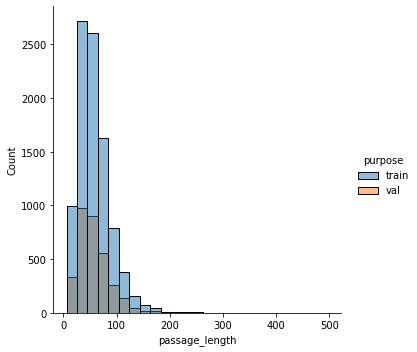

In [ ]:
sns.displot(df, x='passage_length', hue='purpose', bins=25);

Next we are gonna use the pre-trained embedding to vectorize our text samples.

In [ ]:
from gensim.models import KeyedVectors

# this is the file that was recommended in the task, download link:
# https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing
word2vec_path = './drive/MyDrive/GoogleNews-vectors-negative300.bin'

# we only load 200k most common words from Google News corpus 
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=200000) 

In [ ]:
# check some pairs of words similarity according to the model
words = ('dog', 'cat', 'plane', 'helicopter', 'build', 'make')
for i in range(len(words)-1):
    sim = word2vec_model.similarity(words[i], words[i+1])
    print(f'{sim: 0.3} - "{words[i]}" and "{words[i+1]}" similarity')

 0.761 - "dog" and "cat" similarity
 0.183 - "cat" and "plane" similarity
 0.658 - "plane" and "helicopter" similarity
 0.0512 - "helicopter" and "build" similarity
 0.374 - "build" and "make" similarity


In [ ]:
# dimension of embedding vectors
EMBEDDINGS_DIM = 300

# calculate average embedding value of sentence from each word vector
def get_average_vec(word2vec, text):
    if len(text)<1:
        return np.zeros(EMBEDDINGS_DIM)
    
    # if the word is not in the specified number of the most popular words in the vectorizing model, 
    # then we replace their vectors with zero
    vectorized = [word2vec[word] if word in word2vec else np.zeros(EMBEDDINGS_DIM) for word in text]
    
    text_length = len(vectorized)
    summed_vec = np.sum(vectorized, axis=0)
    average_vec = np.divide(summed_vec, text_length)
    return average_vec

In [ ]:
# getting the embeddings
df['passage_embeddings'] = df['passage_prepared'].apply(lambda x: get_average_vec(word2vec_model, x))
df['question_embeddings'] = df['question_prepared'].apply(lambda x: get_average_vec(word2vec_model, x))

# we also vectorize a common bag of words for both: the question and the passage
df['common_embeddings'] = df.apply(lambda x: get_average_vec(word2vec_model, x['passage_prepared'] + x['question_prepared']), axis=1)
# calculating the common vector in one more way: take the half-sum of the vectors of the question and the passage
df['common_embeddings_halfsum'] = df.apply(lambda x: np.divide(np.sum([x['passage_embeddings'], x['question_embeddings']], axis=0), 2), axis=1)

In [ ]:
print(f'passage_embedding matrix sizes: {df.shape[0]}x{EMBEDDINGS_DIM}\n')
print(f'the sentence\'s: "' + ' '.join(df['passage_prepared'][1][:8]) + '... " embedding values starts as:')
print(str(df['passage_embeddings'][1][:5])[:-1], '...')

passage_embedding matrix sizes: 12697x300

the sentence's: "good samaritan law good samaritan law offer legal... " embedding values starts as:
[ 0.04145772  0.00781158  0.01056681  0.06096476 -0.07122599 ...


# Here is an experiment, this was not in the task
Just for fun, let's try the hypothesis here that the semantic similarity of the average vectors of the passage and the question will give the answer "Yes", and their sufficient difference - "No". We will just look at the distance between the vectorized question and the passage, choose some separating alpha, and we will make a prediction.

In [ ]:
# counting dist
df['dist'] = df.apply(lambda x: np.linalg.norm(x['passage_embeddings']-x['question_embeddings']), axis=1)

In [ ]:
def count_accuracy(data, alpha):
    true_pos = data[(data['label'] == True) & (data['dist'] < alpha)].shape[0]
    true_neg = data[(data['label'] == False) & (data['dist'] >= alpha)].shape[0]
    return (true_pos + true_neg) / data.shape[0]

max accuracy is 0.624399464440419
it's 0.0016539340001575642 better then baseline


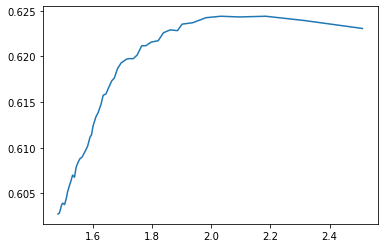

In [ ]:
alphas = []
accuraces = []
for persent in range(900, 1000, 2):
    quant = persent / 1000
    alpha = df['dist'].quantile(q=quant)
    alphas.append(alpha)
    accuraces.append(count_accuracy(df, alpha))

baseline = df[df['label']].shape[0]/df.shape[0]
print(f'max accuracy is {max(accuraces)}')
print(f'it\'s {max(accuraces)-baseline} better then baseline')
plt.plot(alphas, accuraces);

Okay, we got a negligible improvement compared to the classifier, which classifies everything as "True". Moreover, we have achieved this with such parameters when our model is almost indistinguishable from the baseline classifier. The hypothesis is completely non-working.

# 2.2





There was said: "Models on this dataset need to predict an output
class given two pieces of input text, which is
a well studied paradigm" - in the [article](https://arxiv.org/pdf/1905.10044.pdf). However, I could not find good ways to use several sentences as an input of a simple classifier (except for BERT, but this is the next task). In the same article, the authors say that this method, at best, gave an increase of 9% to 62% of the baseline. So I don't have high hopes for this method.

In [ ]:
drop_cols = ['purpose', 'dist', 'question_length', 'passage_length', 'question_embeddings', 'passage_embeddings']
train_df = df[df['purpose'] == 'train'].drop(columns=drop_cols)
val_df = df[df['purpose'] == 'val'].drop(columns=drop_cols)

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(train_df['common_embeddings'].tolist(), train_df['label'].tolist())
train_pred = log_reg.predict(train_df['common_embeddings'].tolist())

In [ ]:
# this cell needs several minutes to work
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import metrics

# compared models
models = {'LinearDiscriminantAnalysis': LinearDiscriminantAnalysis(), 
          'LogisticRegression': LogisticRegression(),
          'DecisionTreeClassifier': DecisionTreeClassifier(),
          'GaussianNB': GaussianNB(),
          'KNeighborsClassifier': KNeighborsClassifier(), 
          'C-SVM': SVC(random_state=42)}

# compared types of embedding vectors using as input for models
data_types = {'common bag': (train_df['common_embeddings'].tolist(), 
                             val_df['common_embeddings'].tolist()), 
              'halfsum bag': (train_df['common_embeddings_halfsum'].tolist(), 
                                     val_df['common_embeddings_halfsum'].tolist())}

# true labels
train_y = train_df['label'].tolist()
val_y = val_df['label'].tolist()

print(f' train_acc \t val_acc \tdata_type\tmodel')
print(f'{base_train: .6}\t{base_val: .6}\t\t\tbaseline')

for model_name, cur_model in models.items():
    for data_type, data in data_types.items():
        # using iterators
        train_X = data[0]
        val_X = data[1]
        model = cur_model 
        
        # training 
        model.fit(train_X, train_y)

        # predicting
        train_predicted = model.predict(train_X)
        val_predicted = model.predict(val_X)
        
        # evaluating
        train_accuracy = metrics.accuracy_score(train_y, train_predicted)
        val_accuracy = metrics.accuracy_score(val_y, val_predicted)

        print(f'{train_accuracy: .6}\t{val_accuracy: .6}\t{data_type}\t{model_name}')

 train_acc 	 val_acc 	data_type	model
 0.623104	 0.621713			baseline
 0.659277	 0.625382	common bag	LinearDiscriminantAnalysis
 0.642304	 0.612538	halfsum bag	LinearDiscriminantAnalysis
 0.652063	 0.623853	common bag	LogisticRegression
 0.642728	 0.619878	halfsum bag	LogisticRegression
 0.998515	 0.600306	common bag	DecisionTreeClassifier
 0.998515	 0.578899	halfsum bag	DecisionTreeClassifier
 0.584704	 0.55841	common bag	GaussianNB
 0.576005	 0.550153	halfsum bag	GaussianNB
 0.743821	 0.606422	common bag	KNeighborsClassifier
 0.756126	 0.61682	halfsum bag	KNeighborsClassifier
 0.707224	 0.643119	common bag	C-SVM
 0.723454	 0.637003	halfsum bag	C-SVM


Obviously, the second way of forming common embeddings with the same weights for the question and the passage proved to be worse. To further improve the results, we will take only the best model and embeddings type.

This method of input into the model is very inefficient. Even accounting the fact that we didn't select the optimal parameters, it is very bad that only one of models was better then the baseline by an integer number of percent and most ones were even worse.

In [ ]:
# I don't recomment to run real calculations here, since they were long (fitting one model took about several minutes)
# ready result would be in the next cell

train_X = train_df['common_embeddings'].tolist()
val_X = val_df['common_embeddings'].tolist()
train_y = train_df['label'].tolist()
val_y = val_df['label'].tolist()

# in real here was a long list of coeffisients, but not set()
for coeff in set():
    # training 
    model = SVC(C=coeff, random_state=42)
    model.fit(train_X, train_y)

    # predicting
    train_predicted = model.predict(train_X)
    val_predicted = model.predict(val_X)
    
    # evaluating
    train_accuracy = metrics.accuracy_score(train_y, train_predicted)
    val_accuracy = metrics.accuracy_score(val_y, val_predicted)

In [ ]:
# paramater C optimisation results for C-SVM model in dict format {<C> : (<train_accuracy>, <val_accuracy>)}
opt_results = \
{0.98: (0.705315, 0.641284),
 0.985: (0.705315, 0.641896),
 0.99: (0.705739, 0.641896),
 0.995: (0.706269, 0.642202),
 1.0: (0.707224, 0.643119),
 1.005: (0.707966, 0.643731),
 1.01: (0.708603, 0.644343),
 1.015: (0.709664, 0.644343),
 1.02: (0.710725, 0.644343),
 1.025: (0.711149, 0.644037),
 1.03: (0.711679, 0.644037),
 1.035: (0.711997, 0.643731),
 1.04: (0.712634, 0.643425),
 1.05: (0.714225, 0.643425),
 1.06: (0.71518, 0.643119),
 1.07: (0.716028, 0.643119),
 1.08: (0.71762, 0.643119),
 1.09: (0.719423, 0.642813),
 1.1: (0.720272, 0.642813),
 1.11: (0.721757, 0.643731),
 1.12: (0.722817, 0.644954),
 1.13: (0.723454, 0.644648),
 1.14: (0.724833, 0.644037),
 1.15: (0.726, 0.643731),
 1.16: (0.726636, 0.643731),
 1.17: (0.727485, 0.643731),
 1.18: (0.728546, 0.643731),
 1.19: (0.729076, 0.644037),
 1.2: (0.730667, 0.644648),
 1.21: (0.732152, 0.644648),
 1.22: (0.733107, 0.644037),
 1.23: (0.734062, 0.644037),
 1.24: (0.735123, 0.643119),
 1.25: (0.735971, 0.643425),
 1.26: (0.736395, 0.643119),
 1.27: (0.737244, 0.643425),
 1.28: (0.737881, 0.643731),
 1.29: (0.738729, 0.644648),
 1.3: (0.73979, 0.644343),
 1.35: (0.74467, 0.647401),
 1.4: (0.748701, 0.646483),
 1.45: (0.752519, 0.647095),
 1.5: (0.755171, 0.648012),
 1.55: (0.759945, 0.648012),
 1.6: (0.762385, 0.64893),
 1.65: (0.76631, 0.648012),
 1.7: (0.769598, 0.648318),
 1.75: (0.772886, 0.648318),
 1.8: (0.775432, 0.646177),
 1.85: (0.778933, 0.645872),
 1.9: (0.782221, 0.64526),
 1.95: (0.784555, 0.64526),
 2.0: (0.786889, 0.644954),
 2.05: (0.789859, 0.644648),
 2.1: (0.79145, 0.64526),
 2.15: (0.793678, 0.645566),
 2.2: (0.798133, 0.64526),
 2.25: (0.800785, 0.646483),
 2.3: (0.803013, 0.646483),
 2.35: (0.805346, 0.647706),
 2.4: (0.807892, 0.646789),
 2.45: (0.809696, 0.646789),
 2.5: (0.811817, 0.646789),
 2.55: (0.813408, 0.647095),
 2.6: (0.815424, 0.646483),
 2.65: (0.817439, 0.647401),
 2.7: (0.81903, 0.648012),
 2.75: (0.82094, 0.647401),
 2.8: (0.822319, 0.648624),
 2.85: (0.823804, 0.649235),
 2.9: (0.824971, 0.649541),
 2.95: (0.825926, 0.649235),
 3.0: (0.827305, 0.648624),
 3.05: (0.828153, 0.648318),
 3.1: (0.829744, 0.648318),
 3.15: (0.832184, 0.649235),
 3.2: (0.833245, 0.650153),
 3.25: (0.834306, 0.650765),
 3.3: (0.835473, 0.651376),
 3.35: (0.836639, 0.649847),
 3.4: (0.8377, 0.649235),
 3.45: (0.83961, 0.649541),
 3.5: (0.840564, 0.650765),
 3.55: (0.842049, 0.651988),
 3.6: (0.84311, 0.651376),
 3.65: (0.843959, 0.650765),
 3.7: (0.844807, 0.649847),
 3.75: (0.845656, 0.650459),
 3.8: (0.847141, 0.650153),
 3.85: (0.848626, 0.650153),
 4.0: (0.852127, 0.649235),
 4.5: (0.861144, 0.64526),
 5.0: (0.870797, 0.642508),
 5.5: (0.881298, 0.640979),
 6.0: (0.888512, 0.63945),
 6.5: (0.896149, 0.638838),
 7.0: (0.90262, 0.642202),
 7.5: (0.906757, 0.643119),
 8.0: (0.910894, 0.643425),
 8.5: (0.914289, 0.639755)}

max accuracy is  0.652
it's  3.028% better then baseline


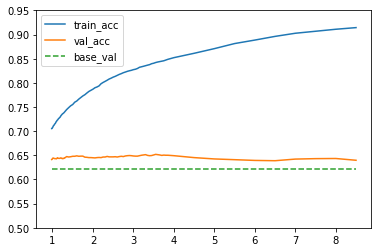

In [ ]:
coeffs = sorted(opt_results.keys())
train_accuracies = [opt_results[c][0] for c in coeffs]
val_accuracies = [opt_results[c][1] for c in coeffs]

print(f'max accuracy is {max(val_accuracies): .4}')
print(f'it\'s {(max(val_accuracies) - base_val)*100: .4}% better then baseline')

plt.ylim([.5,.95])
plt.plot(coeffs, train_accuracies, label='train_acc')
plt.plot(coeffs, val_accuracies, label='val_acc')
plt.plot([min(coeffs),max(coeffs)],[base_val, base_val],'--', label='base_val')
plt.plot
plt.legend()
plt.show()